In [1]:
### Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
sns.set()
%matplotlib inline

In [2]:
### Access MySQL Server
import getpass
from functions import connect_mysql, mysql_list

# Input User id
try:
    # password input hashed
    id = getpass.getpass("id: ") 
except Exception as ex:
    print('Error Occured : ', ex)
#Input password
try:
    # password input hashed
    pwd = getpass.getpass("password: ") 
except Exception as ex:
    print('Error Occured : ', ex)

#host for RDS connection
host = "mdsi-dsp-spr-2020.cehiwpryiego.ap-southeast-2.rds.amazonaws.com"
mydb = connect_mysql(host, id, pwd)

if mydb: 
    print("Connection Successful")

id: ········
password: ········
Connection Successful


In [3]:
from functions import mysql_list
mydb = connect_mysql(host, id, pwd)
mycursor = mydb.cursor()
mycursor.execute("SHOW DATABASES;")
# create a list of database
db_list = mysql_list(mycursor.fetchall())
print(db_list) 
# asx is the database to be used
db = "asx"

['asx', 'information_schema', 'mysql', 'performance_schema']


In [4]:
mydb = connect_mysql(host, id, pwd, db)
mycursor = mydb.cursor()
mycursor.execute("SHOW TABLES;")
tb_list = mysql_list(mycursor.fetchall())
print(tb_list)

['ASX200_index', 'GDP_history_year', 'asx200', 'asx200_June_2020', 'asx200_month', 'asx_all', 'asx_history', 'asx_s_and_p', 'australia_GDP_1960_2020_usd', 'cashrate', 'exchange_rate', 'national_net_lending', 'net_lending_borrowing', 'new_loan_commitment_value_properties_purchased', 's_and_p', 'unemployment_rate', 'vix']


In [5]:
from IPython.display import display, HTML
mydb = connect_mysql(host, id, pwd, db)

for tb in tb_list:
    df = pd.read_sql_query("SELECT * FROM %s" % (tb), con=mydb)
    print(tb)
mydb.close()

ASX200_index
GDP_history_year
asx200
asx200_June_2020
asx200_month
asx_all
asx_history
asx_s_and_p
australia_GDP_1960_2020_usd
cashrate
exchange_rate
national_net_lending
net_lending_borrowing
new_loan_commitment_value_properties_purchased
s_and_p
unemployment_rate
vix


### Generate data from MySQL Server and create new dataframes for EDA and Visualisation
There are three sets of data were used in this section:

`asx200_month` data contains monthly share prices of the ASX 200 Index from 1992-12-01 to 2020-10-12. It was regularly updated during the project. 

`GDP_history_year` data contains yearly Per Capita GDP from 1971-01-01 to 2019-01-01. The record of `2020-01-01` is “0”. Therefore, it is considered as the data is not available when the dataset is acquired. It is removed from the dataset in the later stage of the project.  

`new_loan_commitment_value_properties_purchased` data contains monthly data of new loan commitment of property purchasing from 2002-07-01 to 2020-07-01. Due to limited access, the actual purchase prices and value of properties are not available. Therefore, mortgage data is used in this project because the standard (home) Loan to Value Ratio (LVR) of residential lending in Australia is 80% - 90%. This means buyers usually borrow 80% - 90% of the property value from the bank when purchasing a property. Thus, it is reasonable to assume this data represents 80% - 90% of the value of Australia’s property market. Although the exact numbers are different, the trends should be fairly similar.

In [6]:
# create `gdp_per_cap` and basic cleaning
mydb = connect_mysql(host, id, pwd, db)
gdp_per_cap = round(pd.read_sql_query("SELECT Year, GDP_per_cap, GDP_growth_perc FROM GDP_history_year", con=mydb),2)
gdp_per_cap.head()
gdp_per_cap.tail()

# Remove the last record as it is "0"
gdp_per_cap.drop(gdp_per_cap.tail(1).index,inplace=True)

# Convert data type of 'date' column to date.
gdp_per_cap['Year'] = pd.to_datetime(gdp_per_cap['Year'], format = '%Y-%m-%d')

# Add a column to show the annual difference
year1 = gdp_per_cap[['GDP_per_cap']].shift(1)

year2 = gdp_per_cap[['GDP_per_cap']]

gdp_per_cap[['GDP_growth_dol']] = year2 - year1

# Briefly check dataset
gdp_per_cap.info()
gdp_per_cap.describe()
gdp_per_cap.head()
gdp_per_cap.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 48
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Year             49 non-null     datetime64[ns]
 1   GDP_per_cap      49 non-null     float64       
 2   GDP_growth_perc  49 non-null     float64       
 3   GDP_growth_dol   48 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.9 KB


,Year,GDP_per_cap,GDP_growth_perc,GDP_growth_dol
44,2015-01-01,56755.72,2.19,-5755.07
45,2016-01-01,49971.13,2.77,-6784.59
46,2017-01-01,54066.47,2.37,4095.34
47,2018-01-01,57395.92,2.94,3329.45
48,2019-01-01,54907.10,1.90,-2488.82


In [7]:
# Create `house_commitment` and basic cleaning
mydb = connect_mysql(host, id, pwd, db)
house_commitment = pd.read_sql_query("SELECT * FROM new_loan_commitment_value_properties_purchased", con=mydb)
house_commitment.head()

# Convert data type of 'date' column to date. So that the dataframe could be ordered by date in the following steps. 
house_commitment['Date'] = pd.to_datetime(house_commitment['Date'], format = '%b-%y')

# Renmae the columns with shorter names
house_commitment.columns = ['Date', 'Total', 'Owner Occupied', 'Investment', 'First Home Buyer']

# Add a column to show the annual difference of the "Total"
year3 = house_commitment[['Total']].shift(1)

year4 = house_commitment[['Total']]

house_commitment[['yearly_difference_total']] = year3 - year4

# Briefly check dataset
house_commitment.info()
house_commitment.describe()
house_commitment.head()
house_commitment.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     217 non-null    datetime64[ns]
 1   Total                    217 non-null    float64       
 2   Owner Occupied           217 non-null    float64       
 3   Investment               217 non-null    float64       
 4   First Home Buyer         217 non-null    float64       
 5   yearly_difference_total  216 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.3 KB


,Date,Total,Owner Occupied,Investment,First Home Buyer,yearly_difference_total
212,2020-03-01,19503.1,14434.9,5068.2,4227.6,-251.2
213,2020-04-01,18553.1,13702.2,4851.0,4150.9,950.0
214,2020-05-01,16332.0,12244.2,4087.8,3707.0,2221.1
215,2020-06-01,17376.3,12949.2,4427.1,3834.9,-1044.3
216,2020-07-01,18916.9,14332.8,4584.1,4243.0,-1540.6


In [8]:
# Create `asx200_month` and basic cleaning 
mydb = connect_mysql(host, id, pwd, db)
asx200_month = pd.read_sql_query("SELECT * FROM asx200_month", con=mydb)

# Convert data type of 'date' column to date.
asx200_month['date'] = pd.to_datetime(asx200_month['date'], format = '%Y-%m-%d')

# Add a column to show the annual difference of the "Total"
year5 = asx200_month[['open']].shift(1)

year6 = asx200_month[['open']]

asx200_month[['yearly_difference_open']] = year5 - year6

# Briefly check dataset
asx200_month.info()
asx200_month.describe()
asx200_month.head()
asx200_month.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   date                    336 non-null    datetime64[ns]
 1   open                    336 non-null    float64       
 2   high                    336 non-null    float64       
 3   low                     336 non-null    float64       
 4   close                   336 non-null    float64       
 5   adj_close               336 non-null    float64       
 6   volume                  336 non-null    float64       
 7   yearly_difference_open  335 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 21.1 KB


,date,open,high,low,close,adj_close,volume,yearly_difference_open
331,2020-07-01,5897.899902,6160.600098,5892.799805,5927.799805,5927.799805,14681000.0,-142.199707
332,2020-08-01,5927.799805,6199.200195,5860.700195,6060.500000,6060.500000,15518500.0,-29.899902
333,2020-09-01,6060.500000,6130.799805,5763.200195,5815.899902,5815.899902,17107600.0,-132.700195
334,2020-10-01,5815.899902,6127.399902,5779.600098,6102.200195,6102.200195,4271500.0,244.600098
335,2020-10-12,6102.200195,6132.000000,6093.100098,6132.000000,6132.000000,0.0,-286.300293


### Visualisations
Visualising ASX 200 Index, Per Capita GDP and Housing Commitment in pairs.

#### color schema
Blue for ASX 200 Index

Orange for housing commitment

Purple for GDP

#### ASX 200 Index vs Housing Commitments

In [9]:
# Filter `asx200` with the same date in `new loan commitment` (2002-07-01 ~ 2020-07-01)
start_date_a = "2002-07-01"
end_date_a = "2020-07-01"

after_start_date_a = asx200_month["date"] >= start_date_a
before_end_date_a = asx200_month["date"] <= end_date_a
between_two_dates_a = after_start_date_a & before_end_date_a
asx200_month_a = asx200_month.loc[between_two_dates_a]
asx200_month_a.head()
asx200_month_a.tail()

,date,open,high,low,close,adj_close,volume,yearly_difference_open
327,2020-03-01,6438.899902,6524.299805,4402.500000,5076.799805,5076.799805,32576400.0,578.300293
328,2020-04-01,5076.799805,5563.600098,5022.399902,5522.399902,5522.399902,19759100.0,1362.100098
329,2020-05-01,5522.399902,5922.000000,5169.600098,5755.700195,5755.700195,19852500.0,-445.600098
330,2020-06-01,5755.700195,6198.600098,5705.399902,5897.899902,5897.899902,22199500.0,-233.300293
331,2020-07-01,5897.899902,6160.600098,5892.799805,5927.799805,5927.799805,14681000.0,-142.199707


It is observed from the chart below there are three main periods when the Housing Commitment is opposite with the ASX 200 Index price. 

The first one occurred in 2009 as an impact of the 2007-2008 GFC. Although, both ASX 200 Index and Total Housing Commitment decreased rapidly, the former had a noticeable increase which brought the open price back to the \\$5500 line while the latter went further down and broke through the \\$13,000 million line. Then, the ASX 200 Index fell back to \\$3500 while Total Housing Commitment bounced back significantly to \\$18,000 million in 2009.

The second one occurred in 2011. The ASX 200 Index open price held on strongly between \\$4500 to \\$5000. Meanwhile, Total Housing Commitment fell below $14,000 million from \\$18,000 million. 

The third one started in 2018. In spite of a fall occurred around 2019, the ASX 200 Index went up from \\$5750 to \\$6750. On the other hand, Total Housing Commitment decreased from over \\$20,000 million to \\$16,000 million during the same period of time. 


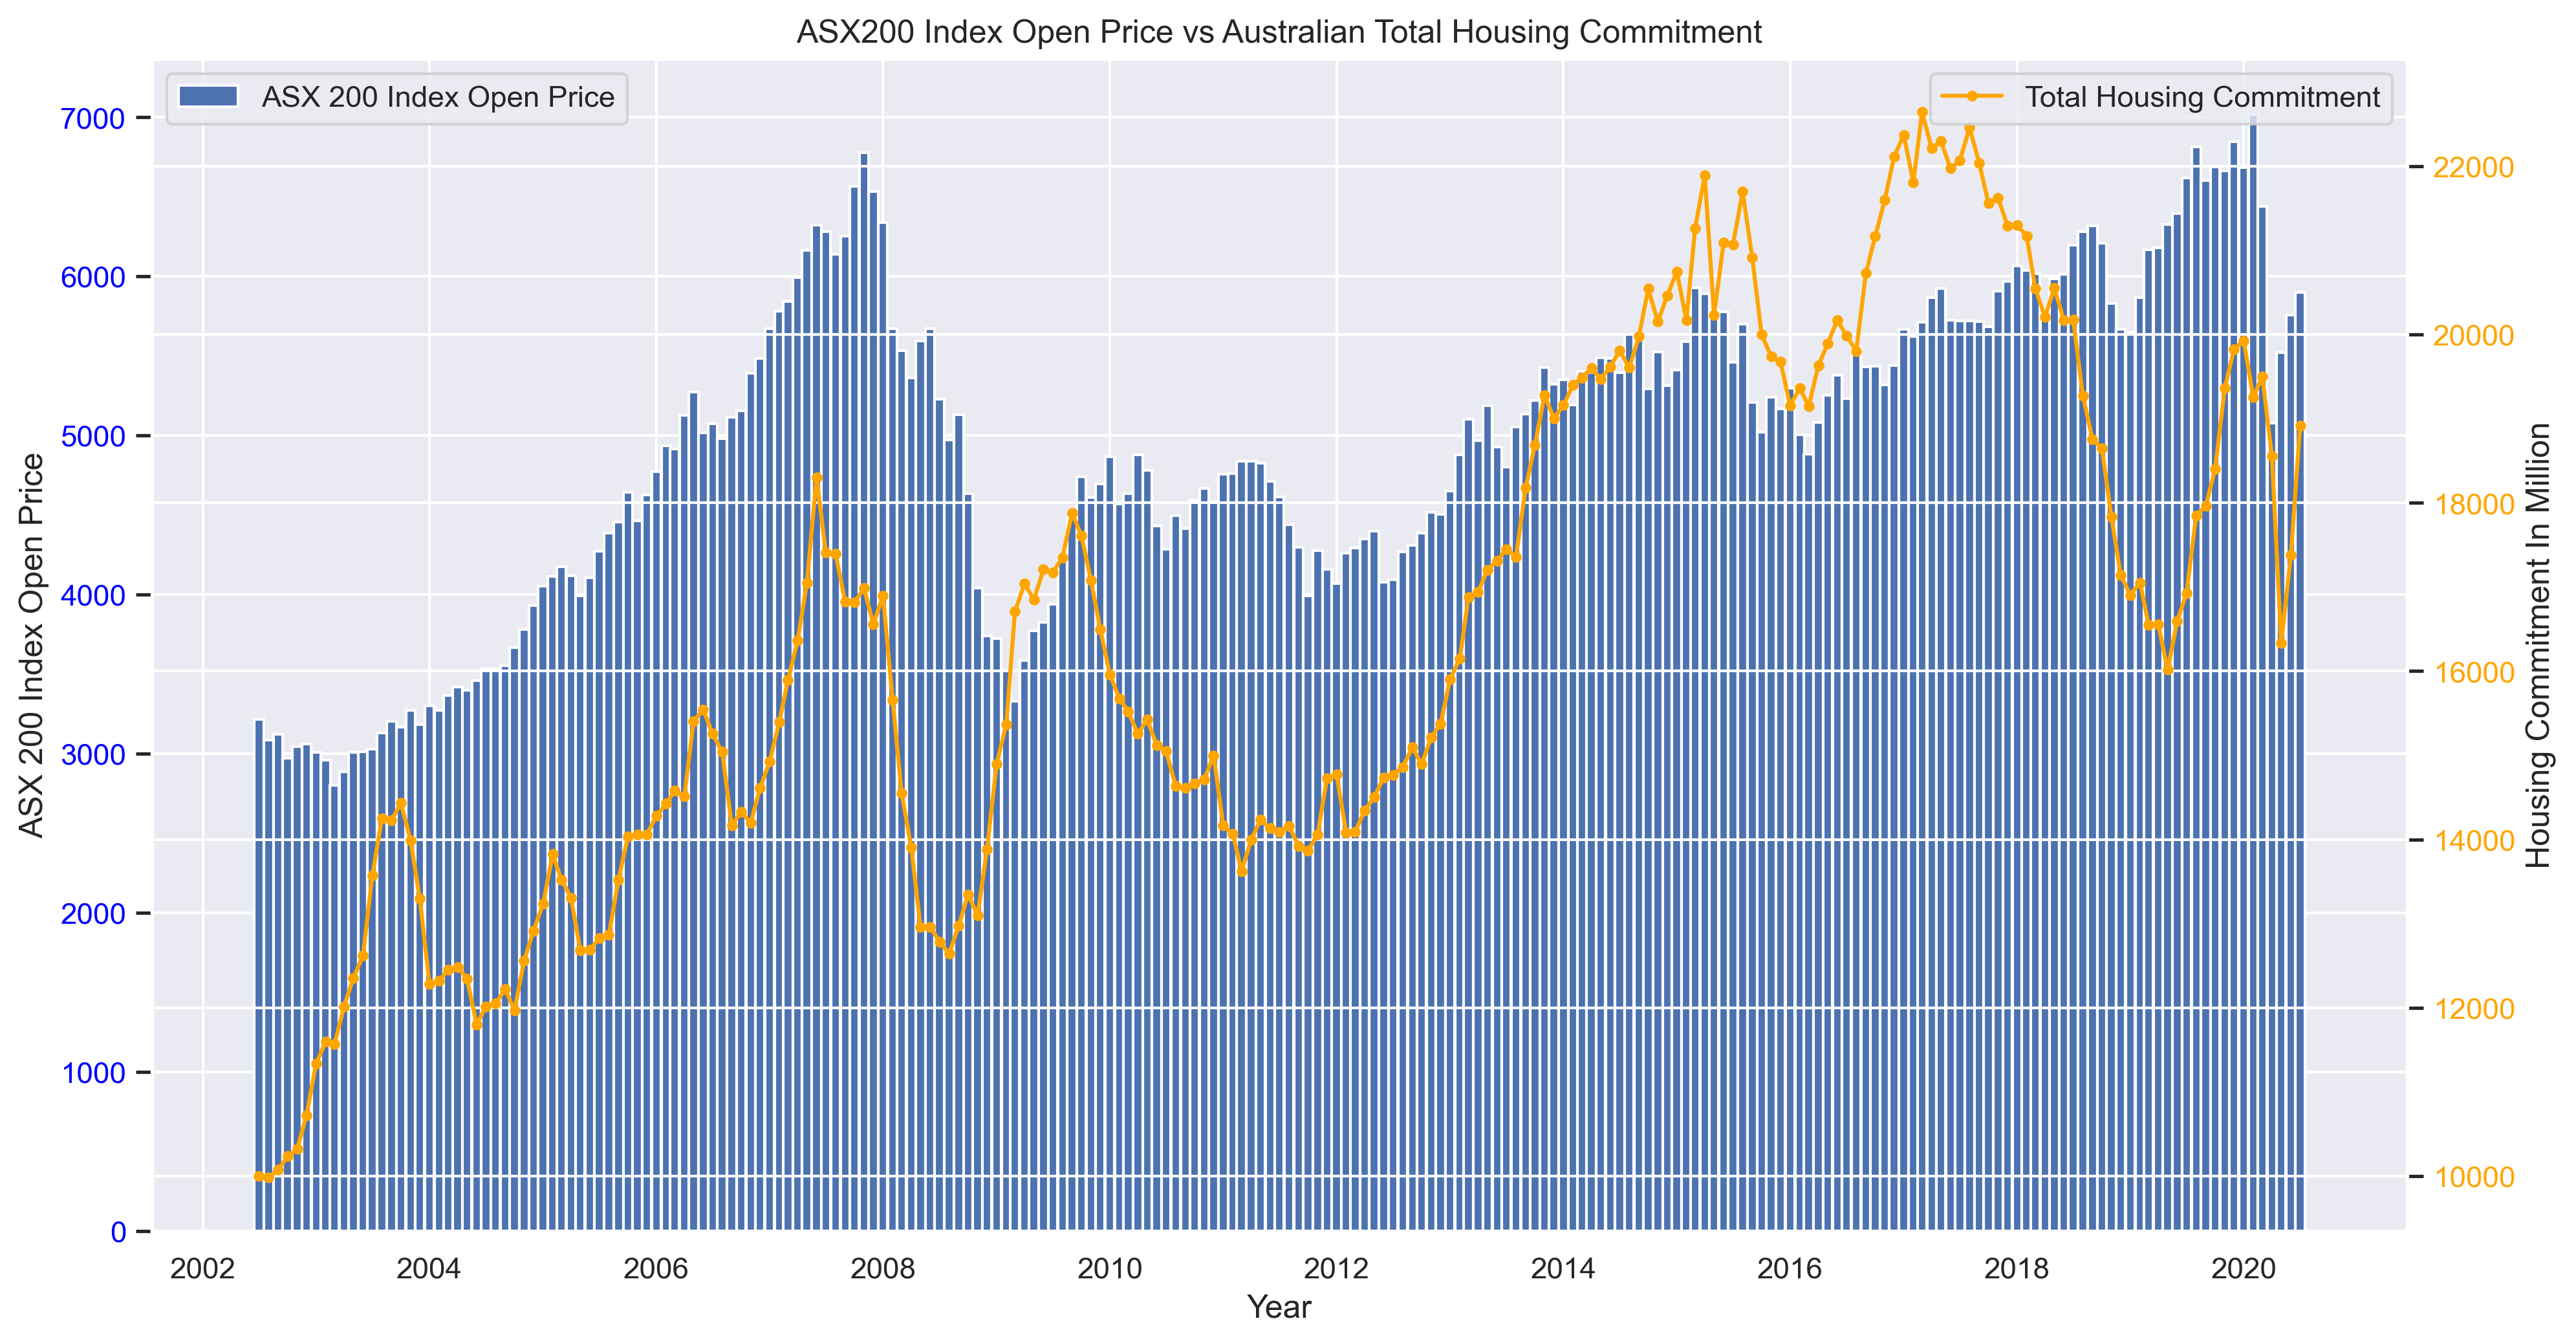

In [10]:
# Create the line charts for ASX 200 Index vs Housing Commitments
total = house_commitment['Total'].tolist()
total_diff = house_commitment['yearly_difference_total'].tolist()
asx200_open_a = asx200_month_a['open'].tolist()
asx200_diff_a = asx200_month_a['yearly_difference_open'].tolist()
month_a = asx200_month_a['date'].tolist()

fig = plt.figure(figsize = (15,8), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index Open Price')
lns1 = axes1.bar(month_a, asx200_open_a, width=30, align = 'center', label = 'ASX 200 Index Open Price')
axes1.tick_params(axis='y', labelcolor="blue")
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:blue'
axes2.set_ylabel('Housing Commitment In Million')
lns2 = axes2.plot(month_a, total, marker = ".", color = "orange", label = "Total Housing Commitment")
axes2.tick_params(axis='y', labelcolor="orange")
axes2.legend(loc = "upper right")

plt.title('ASX200 Index Open Price vs Australian Total Housing Commitment')
plt.show()

In [11]:
# Correlation Coefficient
x = np.array(house_commitment['Total'])
y = np.array(asx200_month_a['open'])
r = np.corrcoef(x, y)
r

array([[1.        , 0.70986612],
       [0.70986612, 1.        ]])

According to the linear regression model below, the (Pearson’s) Correlation Coefficient of Total Housing Commitment and the ASX 200 Index Open Price is 0.70987 which indicates a strong positive linear relationship. This means that it is likely that ASX 200 Index would increase when Housing Commitment increases.

slope: 0.224316    intercept: 1245.162882
R-squared: 0.503910


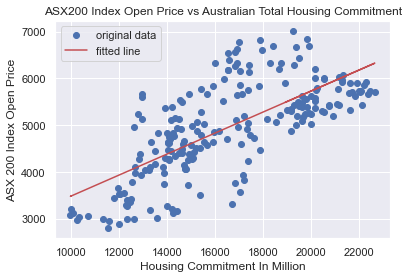

In [12]:
# Simple Linear Regression Model
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)

print("slope: %f    intercept: %f" % (slope, intercept))

print("R-squared: %f" % r_value**2)

plt.plot(x, y, 'o', label='original data')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()

plt.title('ASX200 Index Open Price vs Australian Total Housing Commitment')
plt.xlabel('Housing Commitment In Million')
plt.ylabel('ASX 200 Index Open Price')

plt.show()

#### ASX 200 Index vs Per Capita GDP

In [13]:
# Filter `asx200` and `gdp_per_cap` with the common time period (1992-12-01 ~ 2020-01-01)

## `asx200` (1992-12-01 ~ 2020-01-01)
start_date_b = "1993-01-01"
end_date_b = "2020-01-01"

after_start_date_b = asx200_month["date"] >= start_date_b
before_end_date_b = asx200_month["date"] <= end_date_b
between_two_dates_b = after_start_date_b & before_end_date_b
asx200_month_b = asx200_month.loc[between_two_dates_b]
asx200_month_b.head()
asx200_month_b.tail()


,date,open,high,low,close,adj_close,volume,yearly_difference_open
321,2019-09-01,6604.200195,6775.600098,6503.899902,6688.299805,6688.299805,14700500.0,208.399902
322,2019-10-01,6688.600098,6766.200195,6489.899902,6663.399902,6663.399902,12288700.0,-84.399902
323,2019-11-01,6663.399902,6893.700195,6634.700195,6846.000000,6846.000000,12654500.0,25.200195
324,2019-12-01,6846.000000,6890.000000,6590.100098,6684.100098,6684.100098,11123500.0,-182.600098
325,2020-01-01,6684.100098,7144.899902,6669.200195,7017.200195,7017.200195,11002700.0,161.899902


In [14]:
## `gdp_per_cap` (1992-12-01 ~ 2019-01-01)
start_date_c = "1992-12-01"
end_date_c = "2019-01-01"

after_start_date_c = gdp_per_cap["Year"] >= start_date_c
before_end_date_c = gdp_per_cap["Year"] <= end_date_c
between_two_dates_c = after_start_date_c & before_end_date_c
gdp_per_cap_c = gdp_per_cap.loc[between_two_dates_c]
gdp_per_cap_c.head()
gdp_per_cap_c.tail()

,Year,GDP_per_cap,GDP_growth_perc,GDP_growth_dol
44,2015-01-01,56755.72,2.19,-5755.07
45,2016-01-01,49971.13,2.77,-6784.59
46,2017-01-01,54066.47,2.37,4095.34
47,2018-01-01,57395.92,2.94,3329.45
48,2019-01-01,54907.10,1.90,-2488.82


The chart below shows the trends of ASX 200 Index and Australian Per Capita GDP from year 1992 to 2020. Despite years between 2010 and 2013, the ASX 200 Index and Australian Per Capita GDP has the similar trend. During 2010 and 2013, Per Capita GDP increased from \\$50,000 to the peak which is nearly \\$70,000 then it decreased significantly to the \\$57,000 range. On the other hand, the ASX 200 fluctuated near $4500 from year 2010 to 2013. It then increased to the new peak which is very close to \\$7000, except two small falls in 2016 and year 2019.

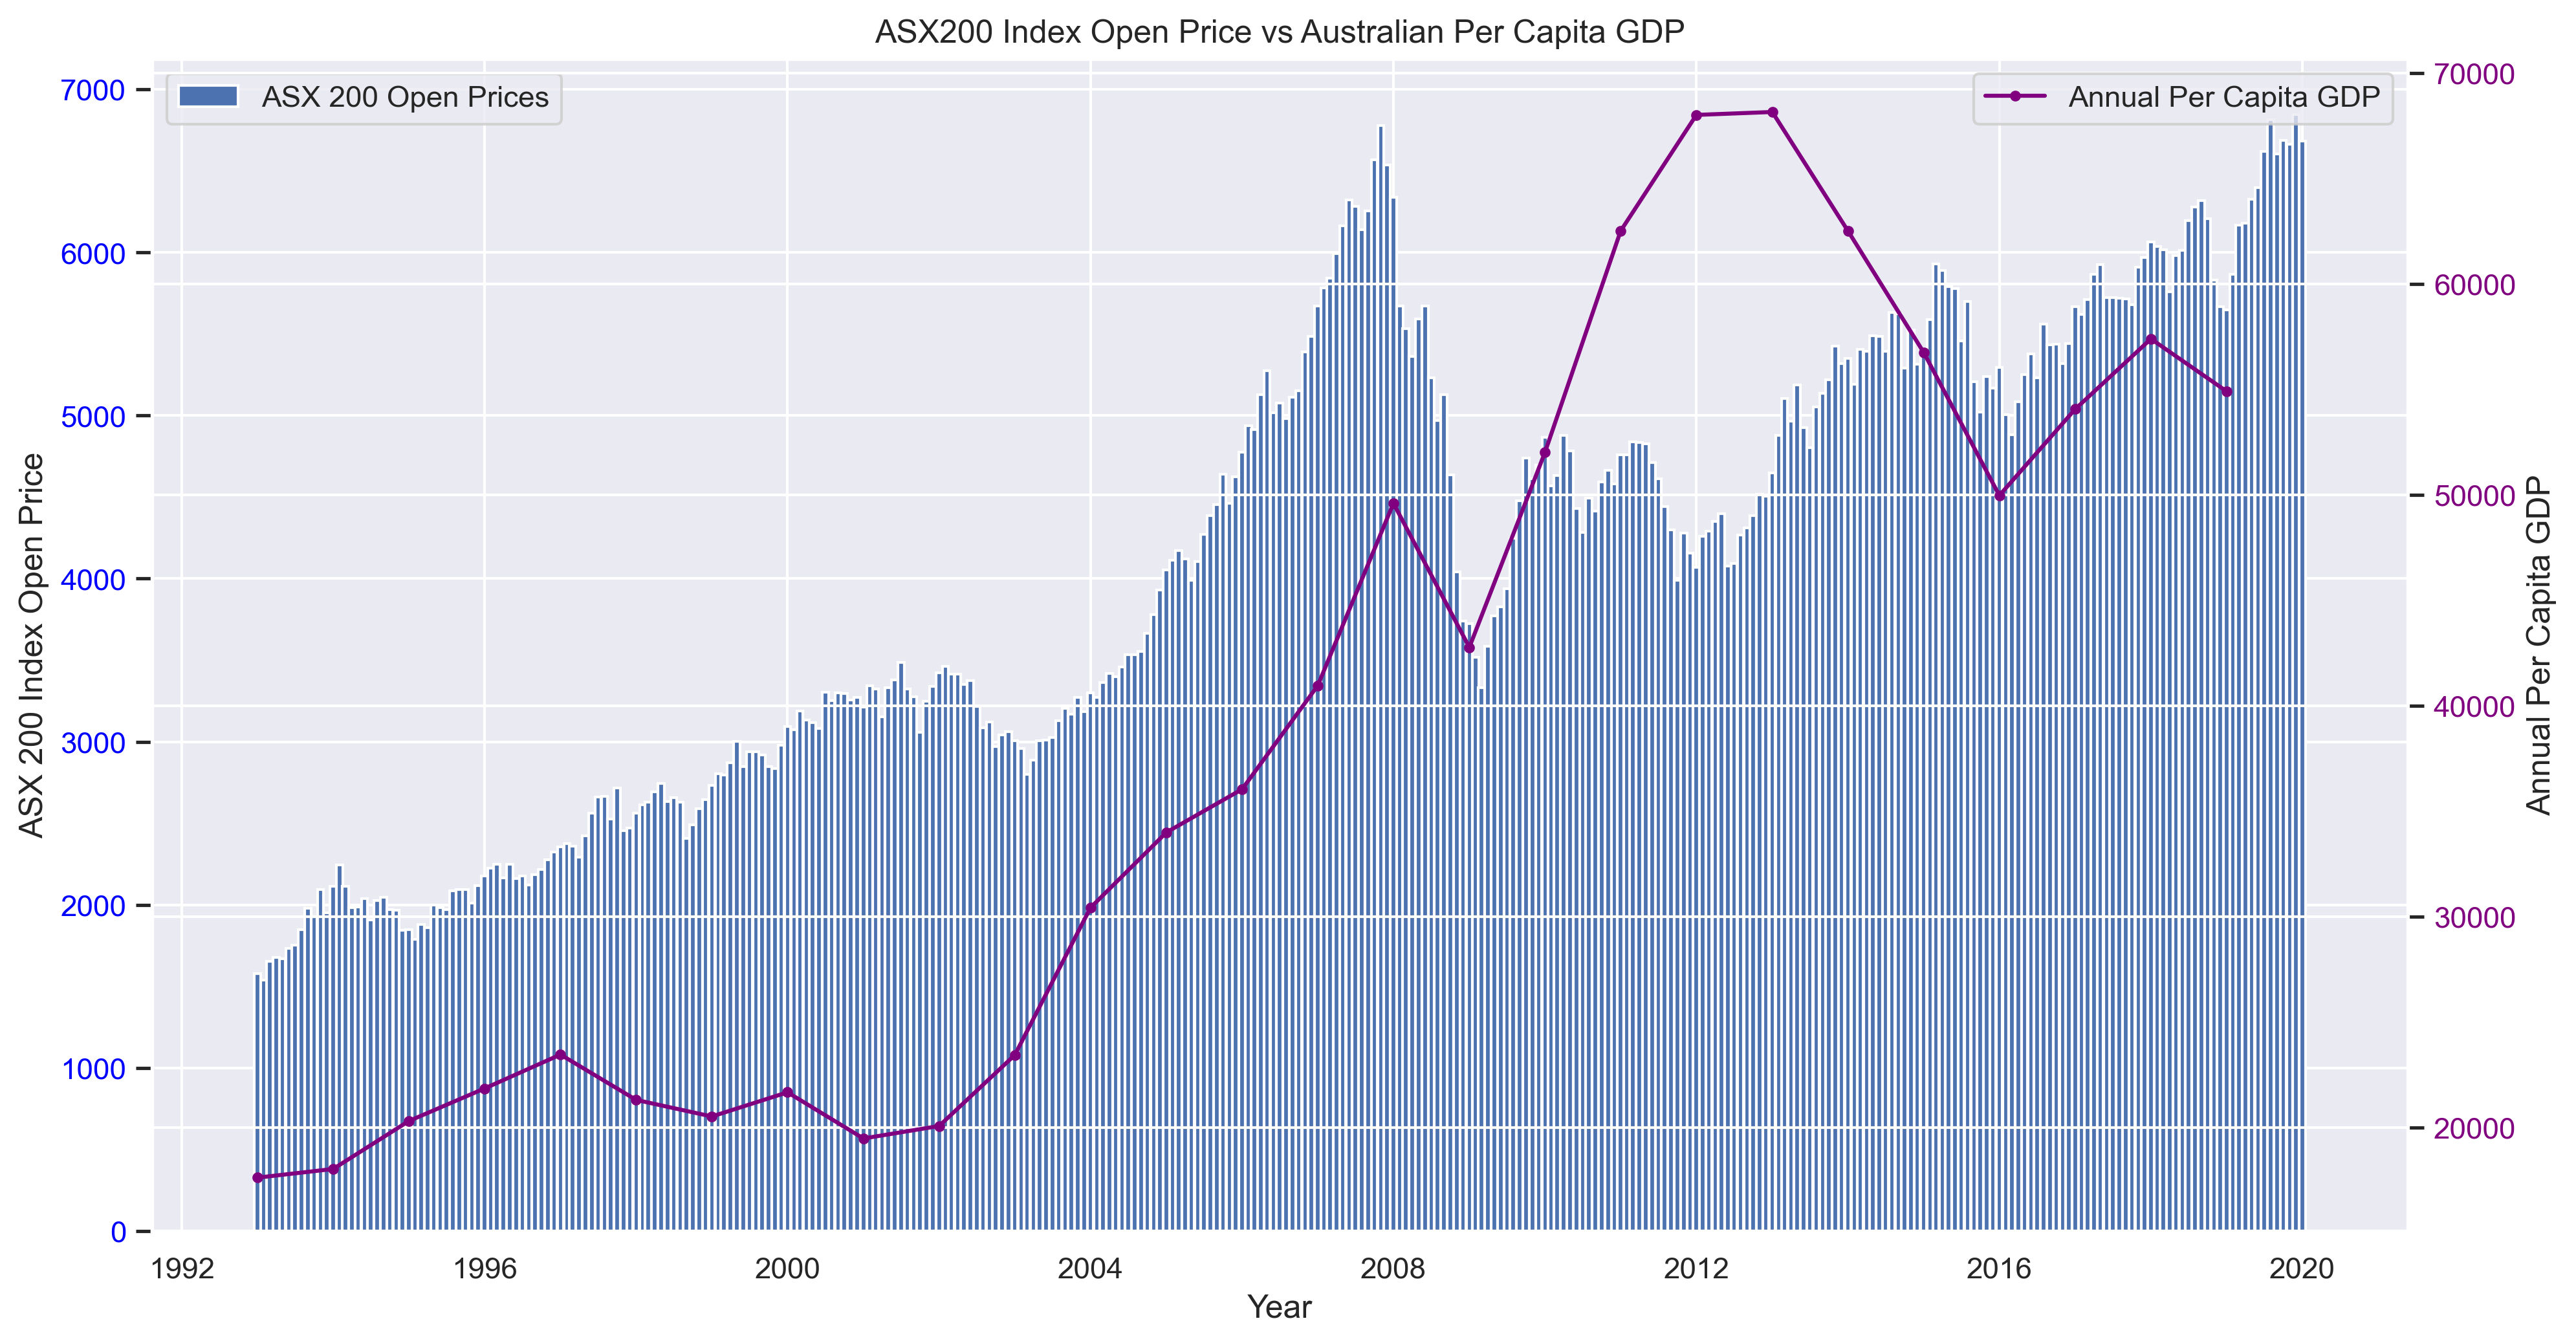

In [15]:
# Create the line charts for ASX 200 Index vs Annual Per Capita GDP 
asx200_open_b = asx200_month_b['open'].tolist()
asx200_diff_b = asx200_month_b['yearly_difference_open'].tolist()
gdp_c = gdp_per_cap_c['GDP_per_cap'].tolist()
gdp_diff_c = gdp_per_cap_c['GDP_growth_dol'].tolist()
year_c = gdp_per_cap_c['Year'].tolist()
month_b = asx200_month_b['date'].tolist()

fig = plt.figure(figsize = (15,8), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('ASX 200 Index Open Price')
lns1 = axes1.bar(month_b, asx200_open_b, width=30, align = 'center', label = 'ASX 200 Open Prices')
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:purple'
axes2.set_ylabel('Annual Per Capita GDP')
lns2 = axes2.plot(year_c, gdp_c, marker = ".", color = "purple", label = "Annual Per Capita GDP")
axes1.tick_params(axis='y', labelcolor="blue")
axes2.tick_params(axis='y', labelcolor="purple")
axes2.legend(loc = "upper right")

plt.title('ASX200 Index Open Price vs Australian Per Capita GDP')

plt.show()

In [16]:
# Create datasets for Correlation Coefficient
asx200_month_b1 = round(asx200_month_b.groupby(asx200_month_b['date'].dt.year)['open'].agg('sum'),2)

asx200_month_b1.drop(asx200_month_b1.tail(1).index,inplace=True)

len(gdp_per_cap_c) == len(asx200_month_b1)

True

In [17]:
# Correlation Coefficient
x1 = np.array(gdp_per_cap_c['GDP_per_cap'])
y1 = np.array(asx200_month_b1)
r1 = np.corrcoef(x1, y1)
r1

array([[1.        , 0.81746143],
       [0.81746143, 1.        ]])

According to the linear regression model below, the (Pearson’s) Correlation Coefficient of Australian Per Capita GDP and ASX200 Index Open Price is 0.81746 which indicates a stronger positive linear relationship.

slope: 0.787173    intercept: 18314.466269
R-squared: 0.668243


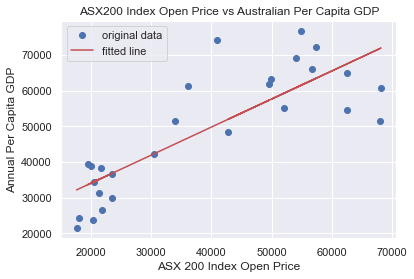

In [18]:
# Simple Linear Regression Model
slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(x1, y1)

print("slope: %f    intercept: %f" % (slope1, intercept1))

print("R-squared: %f" % r_value1**2)

plt.plot(x1, y1, 'o', label='original data')
plt.plot(x1, intercept1 + slope1*x1, 'r', label='fitted line')
plt.legend()

plt.title('ASX200 Index Open Price vs Australian Per Capita GDP')
plt.xlabel('ASX 200 Index Open Price')
plt.ylabel('Annual Per Capita GDP')

plt.show()

#### Per Capita GDP vs Housing Commitments

In [19]:
## filter `gdp_per_cap` again to match `house_commitment` time period (2002-07-01 ~ 2019-01-01)
start_date_d = "2002-07-01"
end_date_d = "2019-01-01"

after_start_date_d = gdp_per_cap["Year"] >= start_date_d
before_end_date_d = gdp_per_cap["Year"] <= end_date_d
between_two_dates_d = after_start_date_d & before_end_date_d
gdp_per_cap_d = gdp_per_cap.loc[between_two_dates_d]
gdp_per_cap_d.head()
gdp_per_cap_d.tail()

,Year,GDP_per_cap,GDP_growth_perc,GDP_growth_dol
44,2015-01-01,56755.72,2.19,-5755.07
45,2016-01-01,49971.13,2.77,-6784.59
46,2017-01-01,54066.47,2.37,4095.34
47,2018-01-01,57395.92,2.94,3329.45
48,2019-01-01,54907.10,1.90,-2488.82


As shown in the line chart below, the main difference between Per Capita GDP and Housing Commitments occurred during the period from 2010 to 2015. Per Capita GDP reached the historical high, which is \\$57000 (roughly), from below \\$45,000 in 2009. Then, it fell back to \\$50,000 in 2018. At the same time, Housing Commitments reached bottom which is below \\$14,000 in 2011 then increased to its peak near \\$22,000. It then jumped above \\$22,000 followed by a noticeable fall of \\$3000 the prior year 2016.

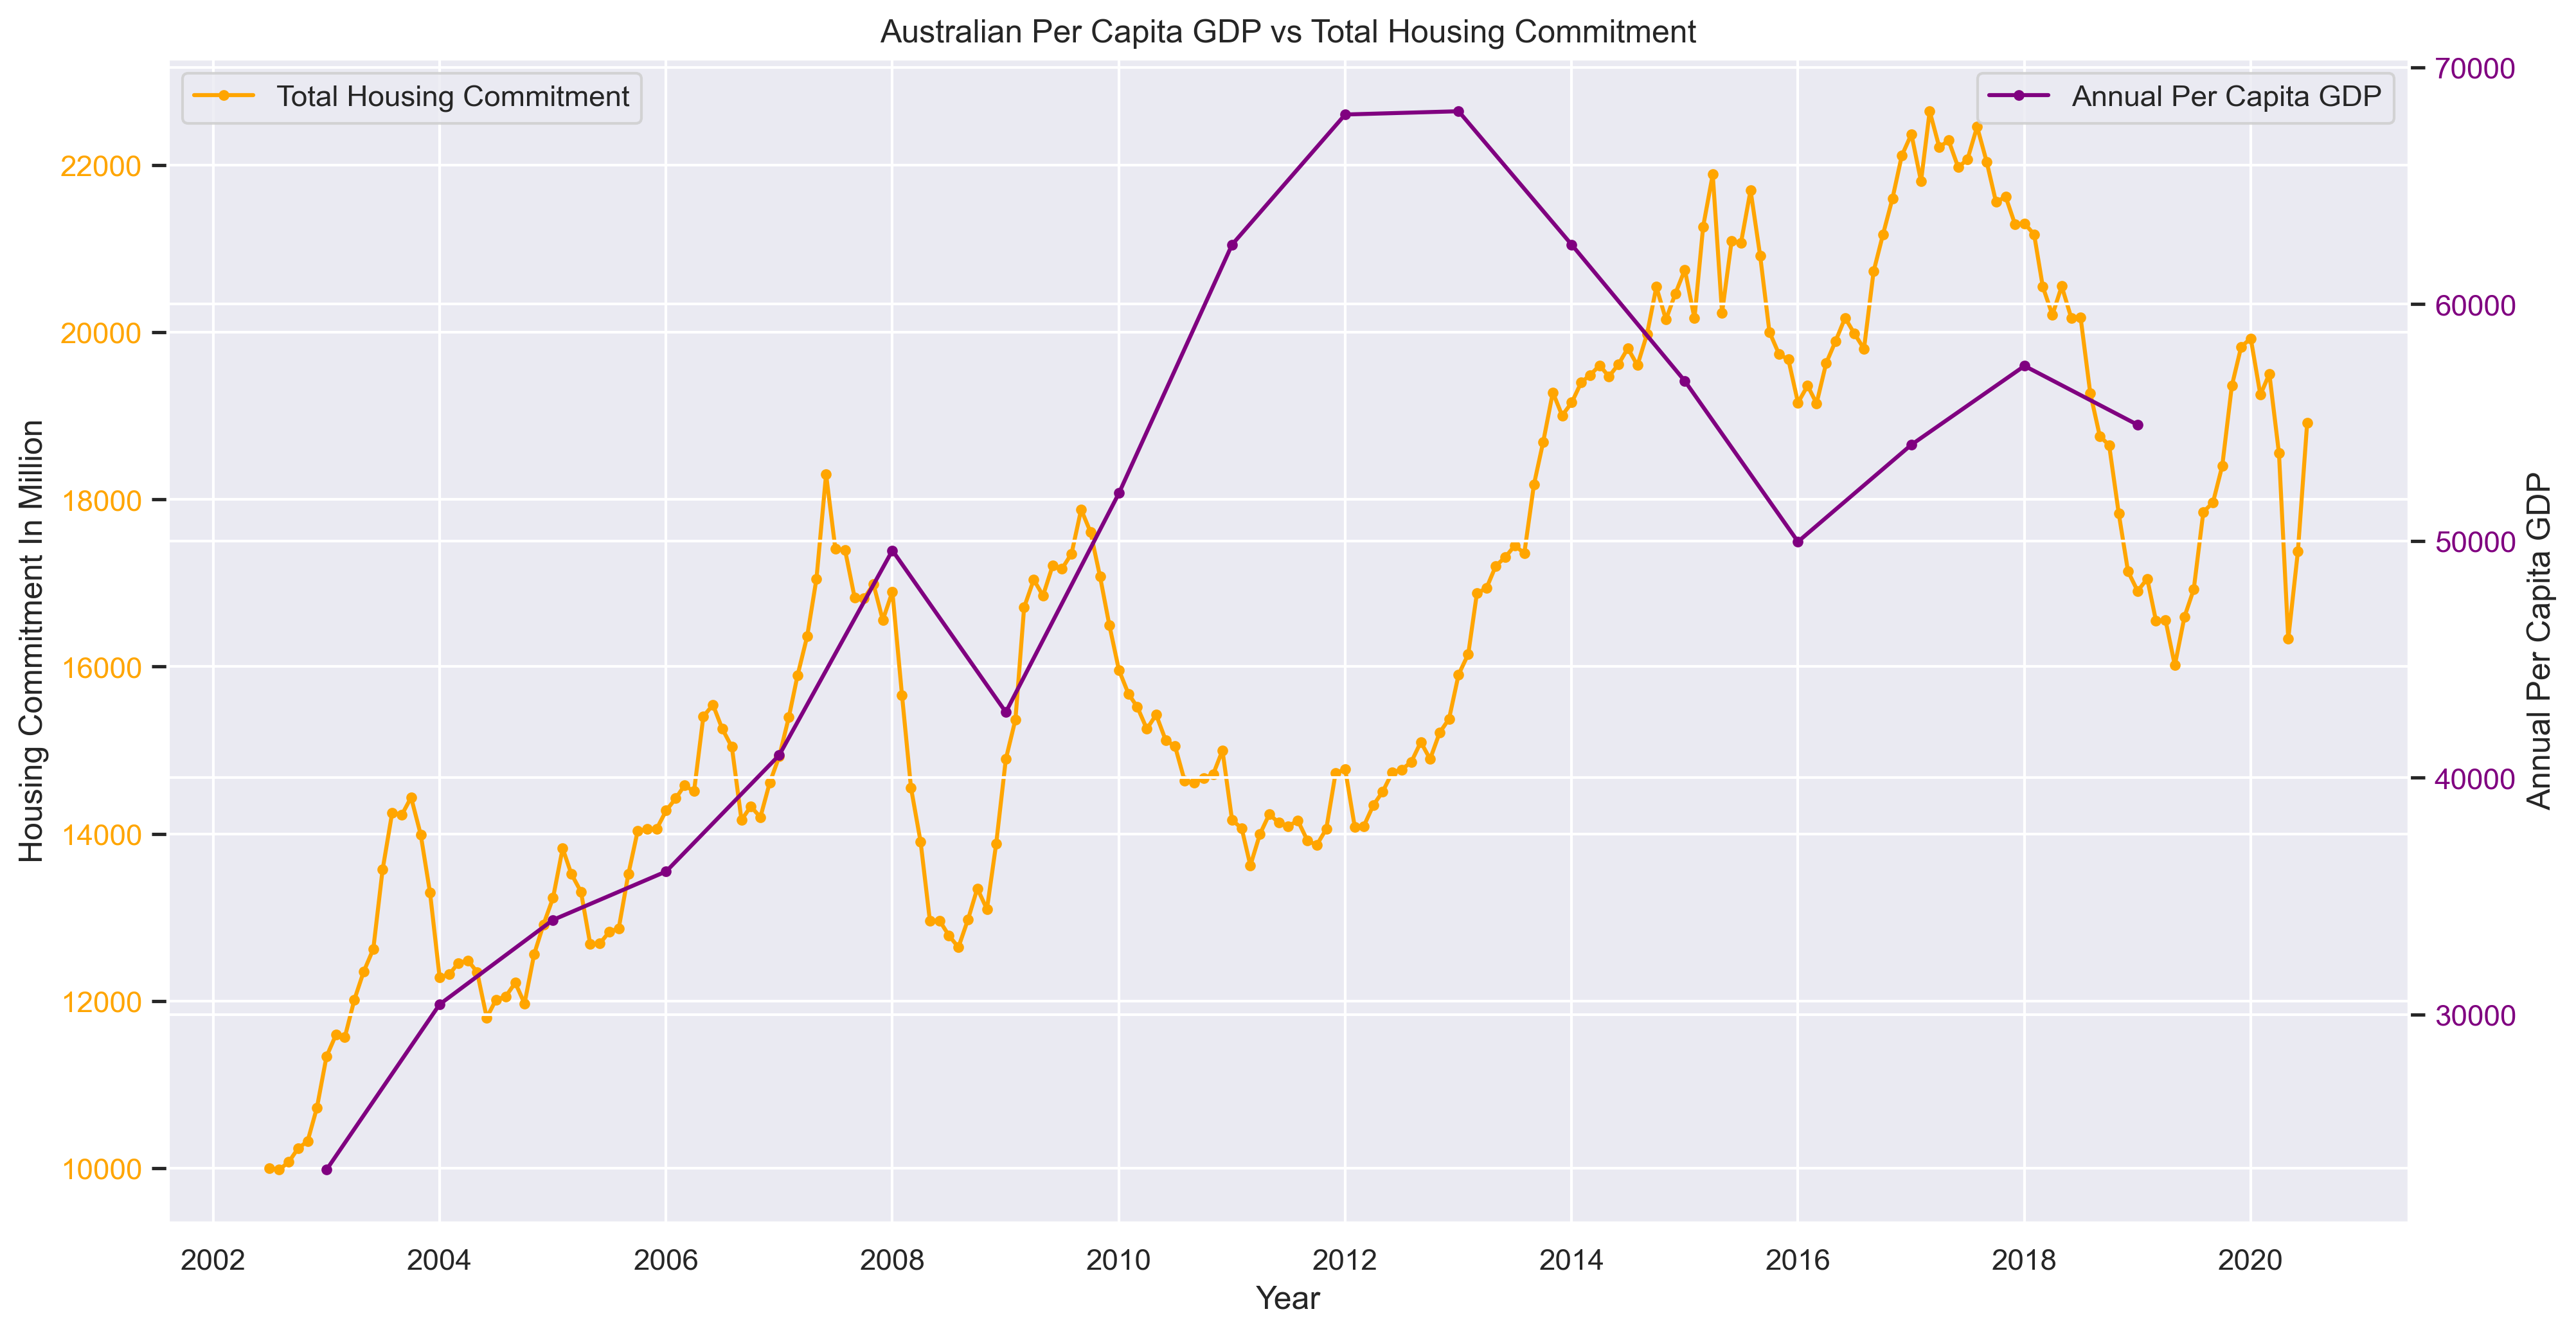

In [20]:
# Create the line charts for Per Capita GDP vs Housing Commitments
total = house_commitment['Total'].tolist()
total_diff = house_commitment['yearly_difference_total'].tolist()
month_c = house_commitment['Date'].tolist()

gdp_d = gdp_per_cap_d['GDP_per_cap'].tolist()
gdp_d_differ = gdp_per_cap_d['GDP_growth_dol'].tolist()
year_d = gdp_per_cap_d['Year'].tolist()

fig = plt.figure(figsize = (15,8), dpi = 300)

axes1 = fig.add_subplot(111)
axes1.set_xlabel('Year')
axes1.set_ylabel('Housing Commitment In Million')
lns1 = axes1.plot(month_c, total,marker = ".", color = "orange", label = "Total Housing Commitment")
axes1.tick_params(axis='y', labelcolor="orange")
axes1.legend(loc = "upper left")

axes2 = axes1.twinx()

color = 'tab:purple'
axes2.set_ylabel('Annual Per Capita GDP')
lns2 = axes2.plot(year_d, gdp_d, marker = ".", color = "purple", label = "Annual Per Capita GDP")
axes2.tick_params(axis='y', labelcolor="purple")
axes2.legend(loc = "upper right")

plt.title('Australian Per Capita GDP vs Total Housing Commitment')
plt.show()

In [21]:
## filter `gdp_per_cap` and `house_commitment` to time period (2003-01-01 ~ 2019-01-01)
start_date_e = "2003-01-01"
end_date_e = "2019-01-01"

after_start_date_e = gdp_per_cap["Year"] >= start_date_e
before_end_date_e = gdp_per_cap["Year"] <= end_date_e
between_two_dates_e = after_start_date_e & before_end_date_e
gdp_per_cap_e = gdp_per_cap.loc[between_two_dates_e]

In [22]:
# Create datasets for Correlation Coefficient
house_commitment1 = house_commitment.groupby(house_commitment['Date'].dt.year)['Total'].agg('sum')

house_commitment1.drop(house_commitment1.tail(1).index,inplace=True)
house_commitment1.drop(house_commitment1.head(1).index,inplace=True)

len(gdp_per_cap_e) == len(house_commitment1)

True

In [23]:
# Correlation Coefficient
x2 = np.array(gdp_per_cap_e['GDP_per_cap'])
y2 = np.array(house_commitment1)
r2 = np.corrcoef(x2, y2)
r2

array([[1.        , 0.50732022],
       [0.50732022, 1.        ]])

According to the linear regression model below, the (Pearson’s) Correlation Coefficient of Australian Per Capita GDP and Housing Commitment is 0.50732 which indicates a moderate positive linear relationship. It is likely that Total Housing Commitment would increase when Australian Per Capita GDP increased.

slope: 1.396308    intercept: 129734.240925
R-squared: 0.257374


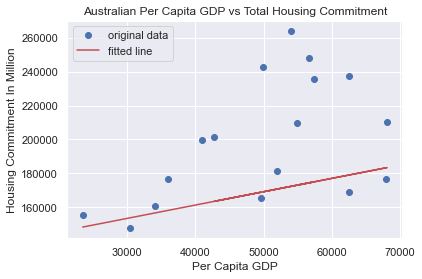

In [24]:
# Simple Linear Regression Model
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(x2, y2)

print("slope: %f    intercept: %f" % (slope2, intercept2))

print("R-squared: %f" % r_value2**2)

plt.plot(x2, y2, 'o', label='original data')
plt.plot(x2, intercept2 + slope1*x2, 'r', label='fitted line')
plt.legend()

plt.xlabel('Per Capita GDP')
plt.ylabel('Housing Commitment In Million')
plt.title('Australian Per Capita GDP vs Total Housing Commitment')

plt.show()